In [1]:
import numpy as np 
np.set_printoptions(threshold=10000,suppress=True) 
import pandas as pd 
import warnings 
import matplotlib.pyplot as plt 
warnings.filterwarnings('ignore') 

Meilleurs paramètres :  {'hidden_layer_sizes': (40, 20)}
Accuracy avec pipeline :  0.7650822669104205
Résultats avec X normalisé

  Classifier: CART
  Accuracy: 0.727 +/- 0.025
  Critere: 0.767 +/- 0.022
  AUC: 0.656 +/- 0.032
  Execution Time: 0.582 seconds

  Classifier: ID3
  Accuracy: 0.723 +/- 0.024
  Critere: 0.769 +/- 0.025
  AUC: 0.663 +/- 0.029
  Execution Time: 0.708 seconds

  Classifier: Decision Stump
  Accuracy: 0.722 +/- 0.018
  Critere: 0.731 +/- 0.019
  AUC: 0.618 +/- 0.028
  Execution Time: 0.094 seconds

  Classifier: MLP
  Accuracy: 0.778 +/- 0.023
  Critere: 0.804 +/- 0.020
  AUC: 0.817 +/- 0.021
  Execution Time: 97.138 seconds

  Classifier: KNN
  Accuracy: 0.763 +/- 0.019
  Critere: 0.789 +/- 0.017
  AUC: 0.765 +/- 0.022
  Execution Time: 1.727 seconds

  Classifier: Bagging
  Accuracy: 0.781 +/- 0.016
  Critere: 0.803 +/- 0.015
  AUC: 0.823 +/- 0.021
  Execution Time: 70.554 seconds

  Classifier: AdaBoost
  Accuracy: 0.790 +/- 0.017
  Critere: 0.807 +/- 0.015


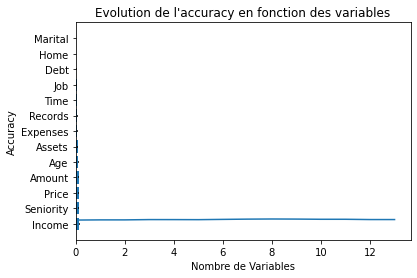

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score 
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier 
from xgboost import XGBClassifier 
import time


#1.
df = pd.read_csv("credit_scoring.csv", sep=";")

array_np = np.array(df)

# Supposons que la colonne 'status' soit la dernière colonne
data = array_np[:, :-1]  # Toutes les colonnes sauf la dernière pour les caractéristiques
status = array_np[:, -1]   # La dernière colonne pour la variable cible 'status'

# taille de l'echantillon
taille = data.shape

# pourcentage exemple
total = len(status)

pos = ((status == 1).sum()/ total) * 100
neg = ((status == 0).sum()/ total) * 100

# separer les donnees 
data_train, data_test, status_train, status_test = train_test_split(data, status, random_state=1)

# 2. 3.

# normalisation des données (ca augmente legerement l'accuracy pour l'arbre, bcp
# pour knn et encore plus pour multi)

# on choisi multi qui a un meilleur score que les autres (0,775)

scaler = StandardScaler()

# pour train
data_train = scaler.fit_transform(data_train)

# pour test
data_test = scaler.transform(data_test)

# arbre = DecisionTreeClassifier(random_state=1)

# arbre.fit(data_train, status_train)
# arbre.predict(data_test)
# acc_arbre= arbre.score(data_test, status_test)

# # Initialiser le classificateur KNN avec k=3
# knn = KNeighborsClassifier(n_neighbors=5)

# # Entraîner le classificateur sur l'ensemble de formation
# knn.fit(data_train, status_train)

# # Prédire les classes pour l'ensemble de test
# status_pred = knn.predict(data_test)

# # Calculer la précision
# acc_knn = metrics.accuracy_score(status_test, status_pred)

multi = MLPClassifier(hidden_layer_sizes=(40,20), random_state=1)
multi.fit(data_train,status_train)

statuspred=multi.predict(data_test)
acc_multi = accuracy_score(status_test,statuspred)

# 4.

from sklearn.ensemble import RandomForestClassifier 
clf = RandomForestClassifier(n_estimators=1000,random_state=1) 
clf.fit(data_train, status_train) 
importances=clf.feature_importances_ 
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0) 
sorted_idx = np.argsort(importances)[::-1] 
nom_cols = df.columns[:-1]
features =nom_cols 
#print(features[sorted_idx]) 
padding = np.arange(data_train.size/len(data_train)) + 0.5  
plt.barh(padding, importances[sorted_idx],xerr=std[sorted_idx], align='center')  
plt.yticks(padding, features[sorted_idx])  
plt.xlabel("Relative Importance") 
plt.title("Variable Importance")  
#plt.show() 


scores=np.zeros(data_train.shape[1]+1)  
for f in np.arange(0, data_train.shape[1]+1):  
    X1_f = data_train[:,sorted_idx[:f+1]] 
    X2_f = data_test [:,sorted_idx[:f+1]] 
    multi.fit(X1_f,status_train) 
    m=multi.predict(X2_f) 
    scores[f]=np.round(accuracy_score(status_test,m),3) 
plt.plot(scores) 
plt.xlabel("Nombre de Variables") 
plt.ylabel("Accuracy") 
plt.title("Evolution de l'accuracy en fonction des variables") 
#plt.show() 

# 5.

prec_multi = precision_score(status_test, statuspred)
scorer = make_scorer((acc_multi + prec_multi)/2 )

param = {
    'hidden_layer_sizes': [(40,20), (50,10), (30,30), (30,10)]
}


grid_search = GridSearchCV(estimator=multi, param_grid=param, scoring=scorer, cv=5)
grid_search.fit(data_train, status_train)

print("Meilleurs paramètres : ", grid_search.best_params_)

# 6.
pipeline = Pipeline([
    ('scaler', StandardScaler()),        # normalisation ou non
    ('pca', PCA(n_components=5)),        # APC ou non
    ('classifier', MLPClassifier(hidden_layer_sizes=(40, 20), random_state=1))  # classificateur
])

pipeline.fit(data_train, status_train)
print("Accuracy avec pipeline : ", accuracy_score(status_test, pipeline.predict(data_test)))

# 7.

clfs = {
    'CART': DecisionTreeClassifier(random_state=1),
    'ID3': DecisionTreeClassifier(criterion='entropy', random_state=1),
    'Decision Stump': DecisionTreeClassifier(max_depth=1, random_state=1),
    'MLP': MLPClassifier(hidden_layer_sizes=(40, 20), random_state=1),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Bagging': BaggingClassifier(n_estimators=200, random_state=1),
    'AdaBoost': AdaBoostClassifier(n_estimators=200, random_state=1),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=1),
    'XGBoost': XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='logloss')
}

def run_classifiers(clfs, X, Y):
    kf = KFold(n_splits=10, shuffle=True, random_state=0)

    resultat = {}
    
    for name, clf in clfs.items():
        start_time = time.time()
        
        # Accuracy (fold cross-validation + moy + ecart-type)
        cv_acc = cross_val_score(clf, X, Y, cv=kf, scoring='accuracy')
        mean_acc = np.mean(cv_acc)
        std_acc = np.std(cv_acc)

        # Précision (pour critere)
        cv_prec = cross_val_score(clf, X, Y, cv=kf, scoring='precision')

        # Critere (fold cross-validation + moy + ecart-type)
        critere = (cv_acc + cv_prec) / 2
        mean_critere = np.mean(critere)
        std_critere = np.std(critere)

        # AUC (fold cross-validation + moy + ecart-type)
        cv_auc = cross_val_score(clf, X, Y, cv=kf, scoring='roc_auc')
        mean_auc = np.mean(cv_auc)
        std_auc = np.std(cv_auc)

        end_time = time.time()
        execution_time = end_time - start_time

        resultat[name] = {
            'Accuracy': (mean_acc, std_acc),
            'AUC': (mean_auc, std_auc),
            'Critere': (mean_critere, std_critere),
            'Execution Time': execution_time
        }

    return resultat


# resultats = run_classifiers(clfs, data, status)

# print("Résultats avec X non normalisé\n")

# # affichage en float avec 3 chiffres apres la virgule
# for clfs, metrics in resultats.items():
#     print(f"  Classifier: {clfs}")
#     print(f"  Accuracy: {metrics['Accuracy'][0]:.3f} +/- {metrics['Accuracy'][1]:.3f}")
#     print(f"  Critere: {metrics['Critere'][0]:.3f} +/- {metrics['Critere'][1]:.3f}")
#     print(f"  AUC: {metrics['AUC'][0]:.3f} +/- {metrics['AUC'][1]:.3f}")
#     print(f"  Execution Time: {metrics['Execution Time']:.3f} seconds\n")

data_normalise = scaler.fit_transform(data)
resultats_norm = run_classifiers(clfs, data_normalise, status)

print("Résultats avec X normalisé\n")

for clfs, metrics in resultats_norm.items():
    print(f"  Classifier: {clfs}")
    print(f"  Accuracy: {metrics['Accuracy'][0]:.3f} +/- {metrics['Accuracy'][1]:.3f}")
    print(f"  Critere: {metrics['Critere'][0]:.3f} +/- {metrics['Critere'][1]:.3f}")
    print(f"  AUC: {metrics['AUC'][0]:.3f} +/- {metrics['AUC'][1]:.3f}")
    print(f"  Execution Time: {metrics['Execution Time']:.3f} seconds\n")